In [ ]:
import pyspark
sc = pyspark.SparkContext('local[*]')

### 1.-Practice: Trending Topics & analysis sentiment (5.0%)

<div class=activity>
Implements the same application realized in activity 2 (mapreduce), but this time using Apache Spark:
1. Calculate de the N Treding Topics (3.75%)
    * Use the json twitter files.
    * Clean-up and filter the input data
    * Calculate the Trending topics (using the word-count and the Top-N models).
    * (optional) Analysis sentiment of hashtgas (+1.0%)
    * Store the N Trending topics in a output text file   
2. Implement the standalone version of the previous Trending Topics application and study its performance (1.25%).
    * Compare the performance with the mapreduce application.
    * Performance vs Number of executors
    * Performance vs Number of cores
    * Scalability vs input data size
    * Scalability vs number of executors/cores

Deliver the jupyter notebook, the standalone application and a pdf file with the performance analysis. 

<div/>

You can use the solution for 

<div class=exercise>

#### 2. Input/output dataset exercise

    Get all the spanish hastags topics and number of ocurrences using input json files and write then in a hadoop sequence file (you can use the textFile, filter,  saveAsNewAPIHadoopFile) 

<div/>

In [56]:
#Cleaner

import os, shutil
import json
import unicodedata

input = sc.textFile("Datasets/Tweets/tweets2.json")
tweets_lowercased = input.map(lambda x: json.loads(x.lower()))
spanish_tweets = tweets_lowercased.filter(lambda t: "es" in t["lang"])
tweets_with_hashtags = spanish_tweets.filter(lambda t: t["entities"]["hashtags"] != [])

In [130]:
#TrendingTopics

topics = tweets_with_hashtags.flatMap(lambda t: map(lambda h: (unicodedata.normalize('NFKD', h["text"]).encode('ascii','ignore'),1), t["entities"]["hashtags"]))\
.reduceByKey(lambda a, b: a + b)
print(topics.collect())

[('con27estasparaelbailandomica', 1), ('soyc', 1), ('noticia', 1), ('valladolid', 1), ('fvf', 1), ('metgala', 1), ('pilarmode', 1), ('villegas', 1), ('valpo', 1), ('fotogalerIa', 1), ('tuitutil', 1), ('frasesdepelicula', 1), ('detox', 1), ('amlo', 1), ('osoriochong', 1), ('zavala', 1)]


In [63]:
#TopNPattern
if os.path.exists("Results/TopNPattern"): 
    shutil.rmtree("Results/TopNPattern")

sc.parallelize(topics.takeOrdered(5, lambda t: -t[1])).saveAsTextFile("Results/TopNPattern")

In [150]:
#HashtagSentiment

def HashtagSentiment(tweet):
    tweetLength = len(unicodedata.normalize('NFKD', tweet["text"]).encode('ascii','ignore'))
    tweetPolarity = 0.0
    hashtags_with_polarity_and_length = []
    
    for word in unicodedata.normalize('NFKD', tweet["text"]).encode('ascii','ignore').split(" "):
        if len(word) > 0:
            if word[0] == "#":
                tweetPolarity += 0
            elif(word in positive_words):
                tweetPolarity += 1
            elif(word in negative_words):
                tweetPolarity -= 1
            
    for hashtag in tweet["entities"]["hashtags"]:
        hashtags_with_polarity_and_length.append(
        (unicodedata.normalize('NFKD', hashtag["text"]).encode('ascii','ignore'), tweetPolarity/tweetLength))
    return hashtags_with_polarity_and_length

positive_words = set(line.strip().lower() for line in open("Word_Classification/positive_words_es.txt"))
negative_words = set(line.strip().lower() for line in open("Word_Classification/negative_words_es.txt"))

sentiments_list = tweets_with_hashtags.map(lambda t: HashtagSentiment(t))
flat_sentiments_list = [item for sublist in sentiments_list.collect() for item in sublist]

print(sc.parallelize(flat_sentiments_list).reduceByKey(lambda a, b: a+b).collect())

[('osoriochong', 0.0), ('pilarmode', 0.0), ('zavala', 0.0), ('valladolid', -0.007352941176470588), ('soyc', 0.006944444444444444), ('valpo', 0.0070921985815602835), ('metgala', 0.0), ('fvf', 0.01639344262295082), ('amlo', 0.0), ('con27estasparaelbailandomica', 0.0), ('villegas', 0.0070921985815602835), ('detox', -0.010869565217391304), ('frasesdepelicula', 0.0), ('tuitutil', 0.0), ('fotogalerIa', 0.0), ('noticia', -0.007352941176470588)]


### 2.- Practice: Calculate dataset statistics  (2.5%)
<div class=activity>
Using the Datasets/ml-100k/u.item data:
1. Read the file and separate all the fields. [textFile, map, split, ...](0.5%)
2. Calculate the following stastistics (0.5%):
    * Number of Movies.  [count, ...]
    * First record.  [first, ...]
    * First 5 records.  [take, ...]
3. Calculate Movies of year X (not take in consideration the blank years) [conver_year, map, filter, reduceByKey, *sortByKey*, collectAsMap, ...] (1.0%)
    * Calculate the max, min, average and standard desviation of the movies by year. [max, min, map, mean,s tdev, ...]
    * Plot a histogram with the number of movies by year (*optional*)    [np.arange, map, filter, distinct, plt.hist, plt.gcf,...]
4. Working with partitions (0.5%)
    * Get the Dataset's automatic number of partitions. [getNumPartitions, ...]
    * Change the number of partitions to 10. [repartition, ...]

The u.item file has information about the items (movies); this is a tab separated list with the following fields.
              movie id | movie title | release date | video release date |
              IMDb URL | unknown | Action | Adventure | Animation |
              Children's | Comedy | Crime | Documentary | Drama | Fantasy |
              Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
              Thriller | War | Western |
The last 19 fields are the genres, a 1 indicates the movie is of that genre, a 0 indicates it is not; movies can be in several generes at once. The movie ids are the ones used in the u.data data set.

In [] there are the spark funtions required to implement the exercise. 

To get the movie year from the date and convert it to integer, you can use the following convert_year function: 

<div/>

In [168]:
def convert_year(x):
     try:
       return int(x[-4:])
     except:
       return 0 # there is a 'bad' data point with a blank year, which we set to 0 and will filter out late


2.Number of movies: 1682

2.First record: [u'1', u'Toy Story (1995)', u'01-Jan-1995', u'', u'http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)', u'0', u'0', u'0', u'1', u'1', u'1', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0']

2.First 5 recors: [[u'1', u'Toy Story (1995)', u'01-Jan-1995', u'', u'http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)', u'0', u'0', u'0', u'1', u'1', u'1', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0'], [u'2', u'GoldenEye (1995)', u'01-Jan-1995', u'', u'http://us.imdb.com/M/title-exact?GoldenEye%20(1995)', u'0', u'1', u'1', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'1', u'0', u'0'], [u'3', u'Four Rooms (1995)', u'01-Jan-1995', u'', u'http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995)', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'1', u'0', u'0'], [u'4', u'Get Shorty (1995)', u'01-Jan-1995', u'', 

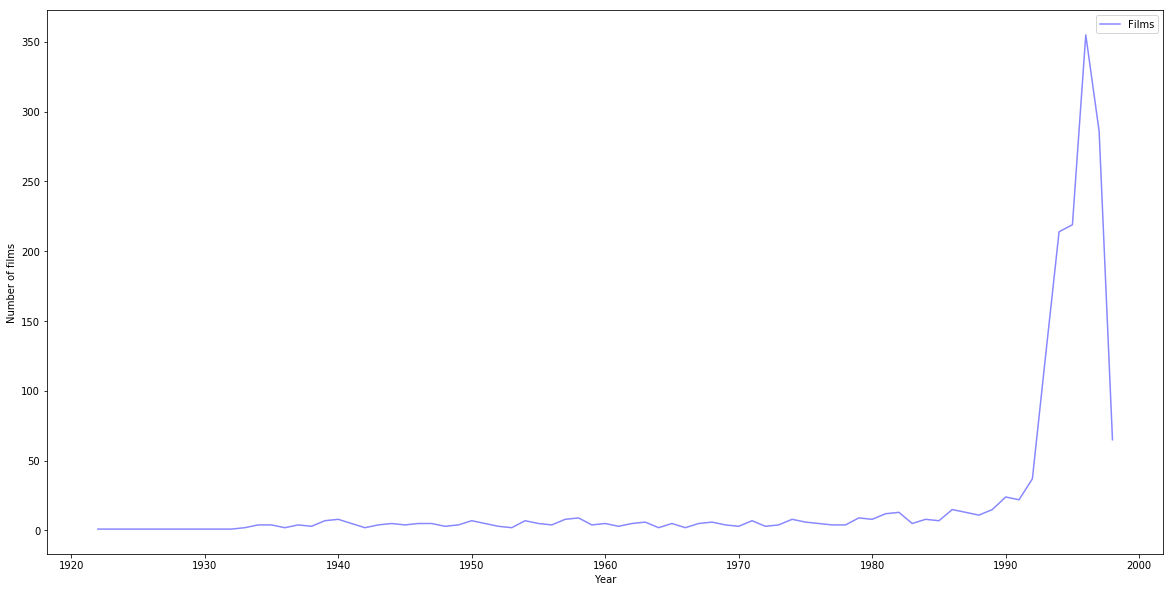

In [223]:
import matplotlib.pyplot as plt

movies_text_file = sc.textFile("Datasets/ml-100k/u.item")
movies = movies_text_file.map(lambda line: line.split("|"))
print("\n2.Number of movies: " + str(movies.count()))
print("\n2.First record: " + str(movies.collect()[0]))
print("\n2.First 5 recors: " + str(movies.collect()[0:5]))

movies_by_year = movies.map(lambda m: (convert_year(m[2]), 1)).filter(lambda t: t[0] != 0)\
.reduceByKey(lambda a, b: a + b).sortByKey()

print("\n3.Movies by year histogram: " + str(movies_by_year.collect()))
print("\n3.Number of movies year: " + str(movies_by_year.filter(lambda t: t[0] == 1995).collect()))
print("\n3.Maximum movies/year: " + str(movies_by_year.max(lambda t : t[1])))
print("\n3.Minimum movies/year: " + str(movies_by_year.min(lambda t : t[1])))
print("\n3.Average movies/year: " + str(movies_by_year.values().mean()))
print("\n3.Standard desviation movies/year: " + str(movies_by_year.values().stdev()))

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

plt.plot(movies_by_year.keys().collect(), map(int, movies_by_year.values().collect()), "#8888ff", label="Films")
plt.xlabel("Year")
plt.ylabel("Number of films")
plt.legend()

print("\n4.Number of partitions: " + str(movies_by_year.getNumPartitions()))
movies_by_year = movies_by_year.repartition(10)
print("\n4.New number of partitions: " + str(movies_by_year.getNumPartitions()))

In [4]:
### 1.- Solution: Calculate dataset statistics


#### 2.- Results: Calculate dataset statistics

Datasets/ml-100k/u.item MapPartitionsRDD[11] at textFile at NativeMethodAccessorImpl.java:-2

1.- Movies fields:
PythonRDD[12] at RDD at PythonRDD.scala:48
()

2.- Number of movies: 1682

2.- First record: [u'1', u'Toy Story (1995)', u'01-Jan-1995', u'', u'http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)', u'0', u'0', u'0', u'1', u'1', u'1', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0']

2.- First 5 records:
[[u'1', u'Toy Story (1995)', u'01-Jan-1995', u'', u'http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)', u'0', u'0', u'0', u'1', u'1', u'1', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0'], [u'2', u'GoldenEye (1995)', u'01-Jan-1995', u'', u'http://us.imdb.com/M/title-exact?GoldenEye%20(1995)', u'0', u'1', u'1', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'1', u'0', u'0'], [u'3', u'Four Rooms (1995)', u'01-Jan-1995', u'', u'http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995)', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'1', u'0', u'0'], [u'4', u'Get Shorty (1995)', u'01-Jan-1995', u'', u'http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995)', u'0', u'1', u'0', u'0', u'0', u'1', u'0', u'0', u'1', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0'], [u'5', u'Copycat (1995)', u'01-Jan-1995', u'', u'http://us.imdb.com/M/title-exact?Copycat%20(1995)', u'0', u'0', u'0', u'0', u'0', u'0', u'1', u'0', u'1', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'1', u'0', u'0']]

3.- Movies by year histogram: 
[(1922, 1), (1926, 1), (1930, 1), (1931, 1), (1932, 1), (1933, 2), (1934, 4), (1935, 4), (1936, 2), (1937, 4), (1938, 3), (1939, 7), (1940, 8), (1941, 5), (1942, 2), (1943, 4), (1944, 5), (1945, 4), (1946, 5), (1947, 5), (1948, 3), (1949, 4), (1950, 7), (1951, 5), (1952, 3), (1953, 2), (1954, 7), (1955, 5), (1956, 4), (1957, 8), (1958, 9), (1959, 4), (1960, 5), (1961, 3), (1962, 5), (1963, 6), (1964, 2), (1965, 5), (1966, 2), (1967, 5), (1968, 6), (1969, 4), (1970, 3), (1971, 7), (1972, 3), (1973, 4), (1974, 8), (1975, 6), (1976, 5), (1977, 4), (1978, 4), (1979, 9), (1980, 8), (1981, 12), (1982, 13), (1983, 5), (1984, 8), (1985, 7), (1986, 15), (1987, 13), (1988, 11), (1989, 15), (1990, 24), (1991, 22), (1992, 37), (1993, 126), (1994, 214), (1995, 219), (1996, 355), (1997, 286), (1998, 65)]

3.- Number of movies year 1994: 214

3.- Maximun movies/year: (1996, 355)

3.- Minimun movies/year: (1922, 1)

3.- Average movies/year: 23.676056338

3.- Standard desviation movies/year: 63.5534098658
()

4.- Num Partitions: 2

4.- New Num Partitions: 10

![Hist Image](imagenes/hist1.png)

### 3.- Practice: pair RDDs (3.0%)

<div class=activity>
Using the Datasets/ml-100k/u.data dataset:
1. Read the ratings data and convert to numeric values (ids to integer and rating to float). [textFile, map, split, int(), float(), ...] (0.5%)
2. Create a pair RDD with the following information: (user id, (rating, item id)) [map, ...] (0.5%)
3. Calculate for each user the sum of the ratings and the number of movies rated. [aggregateByKey, ...] (0.5%)
4. Calculate the average of ratings by movie for each user [mapValues, ...] (0.5%)
5. Calculate how many ratings did each movie receive. [map, reduceByKey, ...](0.5%)
6. High Rating Movies: How many movies had a higher than average (3) rating [map, filter, mapValues, reduceByKey, ...] (1.0%)
    * Map the data to movie ID and rating.
    * Filter the data only for those records with ratings 4 or higher.
    * Map the data to movie ID and the number 1.
    * Add each row of data together.
7. Print the Top 5 the Last 5 rated movies [top, takeOrdered, sortBy,...]   (0.5%)
8. Join the two movie_counts and high_rating_movies datasets using a leftOuterJoin [leftOuterJoin, tale, sortByKey, collect,...] (1.0%)
    * Print the first 5 elements from the orignal and joining datasets. 
    * Print the data for the movid with id = 314.9
9. Calculate the percent of ratings that are higher. [mapValues, top,...] (0.5%)
    * Print the Top 10.

You can choose the apartats you want to implement.

The u.data file has full u data set, 100000 ratings by 943 users on 1682 items. 
* Each user has rated at least 20 movies.  
* Users and items are numbered consecutively from 1.  
* The data is randomly ordered. 

This is a tab separated list with the following fields.
            
	         user id | item id | rating | timestamp. 
             
<div/>

In [290]:
def generate_ratio(x, y):
    try:
       return float(x)/float(y)
    except:
        return 0 #x or y are None

rdd_text_file = sc.textFile("Datasets/ml-100k/u.data")
rdd = rdd_text_file.map(lambda line: line.split("\t"))

print("\n1.User ratings (user id, item id, rating, timestamp): " + str(rdd.collect()[0]))

numerical_rdd = rdd.map(lambda x: (int(float(x[0])), float(x[2]), int(float(x[1]))))
print("\n1.Numerical user ratings (user id, rating, item id): " + str(numerical_rdd.collect()[0]))

paired_numerical_rdd = numerical_rdd.map(lambda x: (x[0], (x[1], x[2])))
print("\n2.Pair RDD (user id, (rating, item id)): " + str(paired_numerical_rdd.collect()[0]))

aggregated_numerical_rdd = paired_numerical_rdd.aggregateByKey((0.0, 0.0),\
                               lambda acc, val: (val[0] + acc[0], acc[1] + 1),\
                               lambda acc1, acc2: (acc1[0]+acc2[0], acc1[1]+acc2[1]))

print("\n3.Agregate user ratings and movies ((user id, (rating sum, number of movies)):" 
      + str(aggregated_numerical_rdd.takeOrdered(5, lambda x: x[0])))

user_average_rdd = aggregated_numerical_rdd.mapValues(lambda x:(x[0]/x[1]))
print("\n4.User average ratings ((user id, rating sum/number of movies):" 
      + str(user_average_rdd.takeOrdered(5, lambda x: x[0])))

movies_rating_count = paired_numerical_rdd.map(lambda x : (x[1][1], 1)).reduceByKey(lambda a,b: a+b)
print("\n5.Movie number of ratings (movie id, ratings number):" 
      + str(movies_rating_count.take(5)))

high_rating_movies = paired_numerical_rdd.map(lambda x : (x[1][1], x[1][0])).filter(lambda x : x[1] >= 4.0)\
           .map(lambda x : (x[0], 1)).reduceByKey(lambda a,b: a+b)
print("\n6.High Rating Movies:" 
      + str(high_rating_movies.takeOrdered(5, lambda x: x[0])))

print("\n7.Top 5 Rated movies:" 
      + str(movies_rating_count.takeOrdered(5, lambda x: -x[1])))

print("\n7.Last 5 Rated movies:" 
      + str(movies_rating_count.takeOrdered(5, lambda x: x[1])))

movies_leftOuterJoin = movies_rating_count.leftOuterJoin(high_rating_movies)
print("\n8.Join the two movie_counts and high_rating_movies datasets using a leftOuterJoin:" 
     + str(movies_leftOuterJoin.take(5)))

print("\n8.Movie with id = 314:" 
     + str(movies_leftOuterJoin.filter(lambda x : x[0] == 314).collect()))

print("\n9.Top higher rates movie (movie id, (high ratings number/ ratings number):" 
     + str(movies_leftOuterJoin.mapValues(lambda x : (generate_ratio(x[1], x[0])))\
           .takeOrdered(10, lambda x: -x[1])))


1.User ratings (user id, item id, rating, timestamp): [u'196', u'242', u'3', u'881250949']

1.Numerical user ratings (user id, rating, item id): (196, 3.0, 242)

2.Pair RDD (user id, (rating, item id)): (196, (3.0, 242))

3.Agregate user ratings and movies ((user id, (rating sum, number of movies)):[(1, (982.0, 272.0)), (2, (230.0, 62.0)), (3, (151.0, 54.0)), (4, (104.0, 24.0)), (5, (503.0, 175.0))]

4.User average ratings ((user id, rating sum/number of movies):[(1, 3.610294117647059), (2, 3.7096774193548385), (3, 2.7962962962962963), (4, 4.333333333333333), (5, 2.874285714285714)]

5.Movie number of ratings (movie id, ratings number):[(2, 131), (4, 209), (6, 26), (8, 219), (10, 89)]

6.High Rating Movies:[(1, 321), (2, 51), (3, 34), (4, 122), (5, 39)]

7.Top 5 Rated movies:[(50, 583), (258, 509), (100, 508), (181, 507), (294, 485)]

7.Last 5 Rated movies:[(814, 1), (830, 1), (852, 1), (1122, 1), (1130, 1)]

8.Join the two movie_counts and high_rating_movies datasets using a leftOute

In [5]:
### 2.- Solution: pair RDDs (3.5%)

#### 3.- Result: pair RDDs (3.0%)

1.- User ratings (user id, item id, rating, timestamp):[u'196', u'242', u'3', u'881250949']

1.- Numerical user ratings (user id, rating, item id): (196, 3.0, 242)

2.- Pair RDD (user id, (rating, item id)): (196, (3.0, 242))

3.- Agregate user ratings and movies ((user id, (rating sum, number of movies)): 
[(2, (230.0, 62.0)), (4, (104.0, 24.0)), (6, (767.0, 211.0)), (8, (224.0, 59.0)), (10, (774.0, 184.0))]

4.- User average ratings ((user id, rating sum/number of movies): 
[(2, 3.7096774193548385), (4, 4.333333333333333), (6, 3.6350710900473935), (8, 3.7966101694915255), (10, 4.206521739130435)]

5.- Movie number of ratings (movie id, ratings number): 
[(2, 131), (4, 209), (6, 26), (8, 219), (10, 89)]

6.- 1447 high rating movies (movie id, high ratings number): 
[(2, 51), (4, 122), (6, 15), (8, 155), (10, 59)]

7.- Top 5 rating movies: 
[(50, 501), (100, 406), (181, 379), (127, 351), (174, 348)]
[(50, 501), (100, 406), (181, 379), (127, 351), (174, 348)]
[(50, 501), (100, 406), (181, 379), (127, 351), (174, 348)]
7.- Last 5 rating movies: 
[(36, 1), (440, 1), (548, 1), (556, 1), (600, 1)]

8.- Movie rating counts dataset (movie id, ratings number):     [(2, 131), (4, 209), (6, 26), (8, 219), (10, 89)]

8.- High rating movies dataset (movie id, high ratings number): [(2, 51), (4, 122), (6, 15), (8, 155), (10, 59)]

8.- Join (movie id, (ratings number, high ratings number):      [(2, (131, 51)), (4, (209, 122)), (6, (26, 15)), (8, (219, 155)), (10, (89, 59))]

9.- Info for movie id 314: (314, (5, None))

9.- Top higher rates movie (movie id, (high ratings number/ ratings number):
[(814, 1.0), (1064, 1.0), (1080, 1.0), (1122, 1.0), (1130, 1.0), (1396, 1.0), (1398, 1.0), (1452, 1.0), (1458, 1.0), (1482, 1.0)]


In [6]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/Exercise.css", "r").read()
    return HTML(styles)
css_styling()